In [12]:
import requests
import pandas as pd
import numpy as np
import datetime
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import pytz
%matplotlib inline

In [22]:


def get_access_token(address):

    r = requests.post(address + "/api/auth/login",
                      json={'username': 'meazonpro@meazon.com', 'password': 'meazonpro1'}).json()
    # acc_token is the token to be used in the next request
    acc_token = 'Bearer' + ' ' + r['token']
    return acc_token


def get_devid(address, device, entity):
    """
    Retrieves the device ID for the given device name.
    """
    acc_token = get_access_token(address)
    
    response = requests.get(
        url=f"{address}/api/tenant/{entity}s",
        params={entity+"Name": device},
        headers={
            'Content-Type': 'application/json',
            'Accept': '*/*',
            'X-Authorization': acc_token
        }
    )
    return response.json()['id']['id']

def get_attr(address, acc_token, devid, month, start_time, end_time):
    print(start_time, end_time)
    attrib = {}
    # get sqmt
    attr = 'unitsSquareMeters'
    r2 = requests.get(
        url=address + "/api/plugins/telemetry/ASSET/" + devid + "/values/attributes?keys="+attr,
        headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()
    attrib['sqmt'] = r2[0]['value']['Eugenides Foundation']

   
    print(attrib)

    return attrib


def read_data(address, devid, acc_token, start_time, end_time, descriptors, entity, tmzn):
    """
    Reads data from the API and returns a DataFrame.
    """

    url = f"{address}/api/plugins/telemetry/{entity.upper()}/{devid}/values/timeseries"
    # try:
    response = requests.get(
        url=url,
        params={
            "keys": descriptors,
            "startTs": start_time,
            "endTs": end_time,
            "agg": "NONE",
            "limit": 1000000
        },
        headers={
            'Content-Type': 'application/json',
            'Accept': '*/*',
            'X-Authorization': acc_token
        }
    )
    r2 = response.json()
    
    
    if r2:
        df = pd.concat(
            [pd.DataFrame(r2[desc]).rename(columns={'value': desc}).set_index('ts') for desc in r2],
            axis=1
        )
        df.reset_index(drop=False, inplace=True)
        df['ts'] = pd.to_datetime(df['ts'], unit='ms')
        df['ts'] = df['ts'].dt.tz_localize('utc').dt.tz_convert(tmzn)
        df.sort_values(by=['ts'], inplace=True)
        df.set_index('ts', inplace=True, drop=True)

        for col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].astype('int')
            
            
    else:
        df = pd.DataFrame([])
    # except Exception as e:
    #     print(f"Error reading data for device {devid}: {e}")
    return df
        


In [28]:
def plot_error(df,name, month, year, prefix):
    fig, ax1 = plt.subplots(figsize=(10, 8.0))

    # Bar plot on primary y-axis
    ax1.bar(df.index, df['delta'], color='tab:blue')
    ax1.set_ylabel('Wh', color='tab:blue')
    ax1.set_xlabel('Index')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a second y-axis for the line plot
    ax2 = ax1.twinx()
    ax2.plot(df.index, df['diff'], color='r', marker='o')
    ax2.set_ylabel('Relevant diff to average value %', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    ax1.set_xticks(df.index)
    ax1.set_xticklabels(df.index, rotation=90)
    plt.title('Daily Consumption & distance from mean, meter '+name+'_'+str(month)+'_'+str(year), fontsize=14)
    plt.show()

    fig.tight_layout()
    fig.savefig(prefix+'check_failure'+name+'.png',dpi=150)


110.101.004386


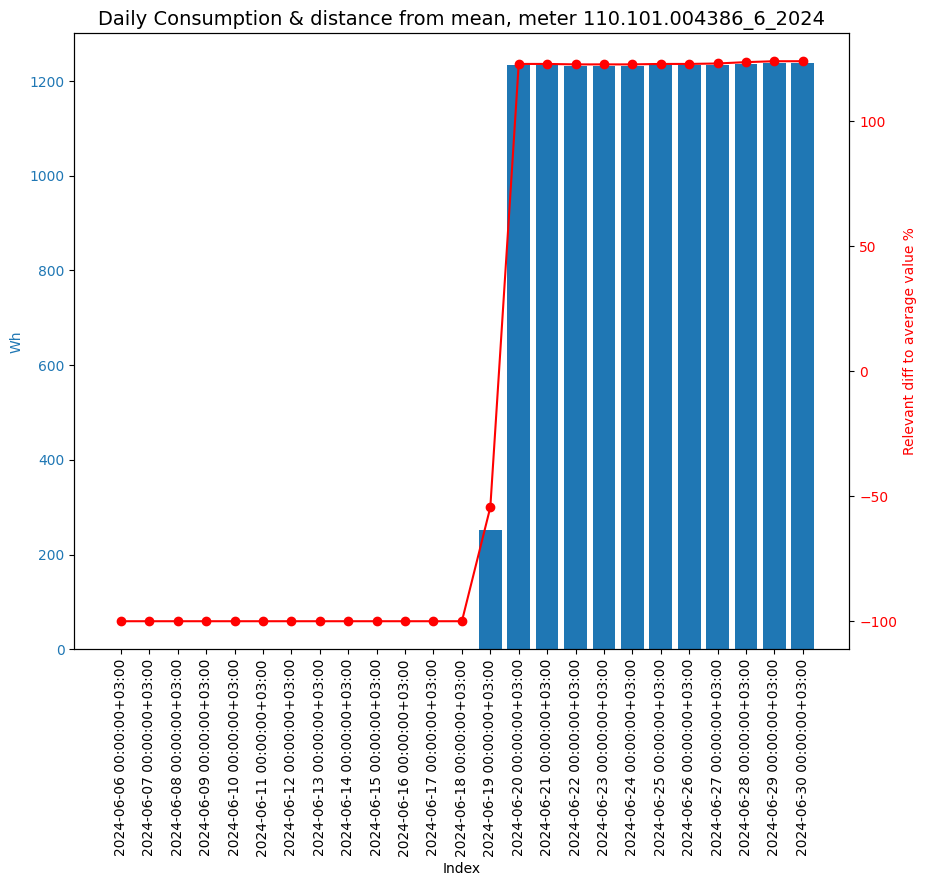

110.101.004389


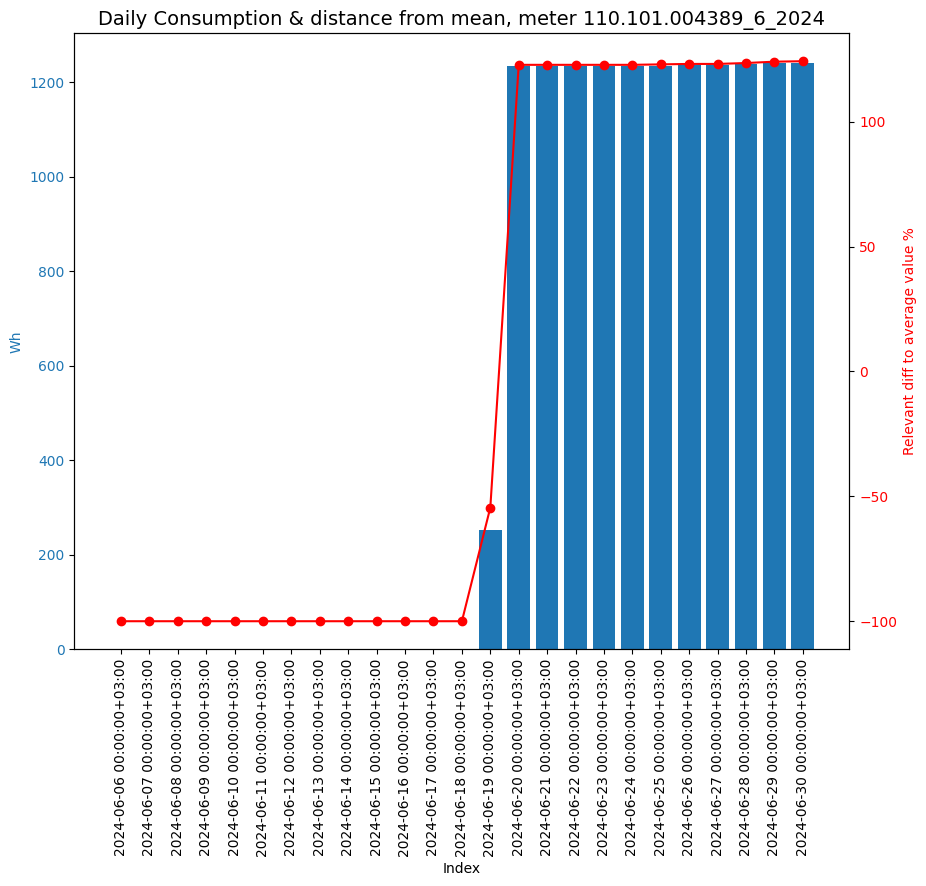

110.101.004380


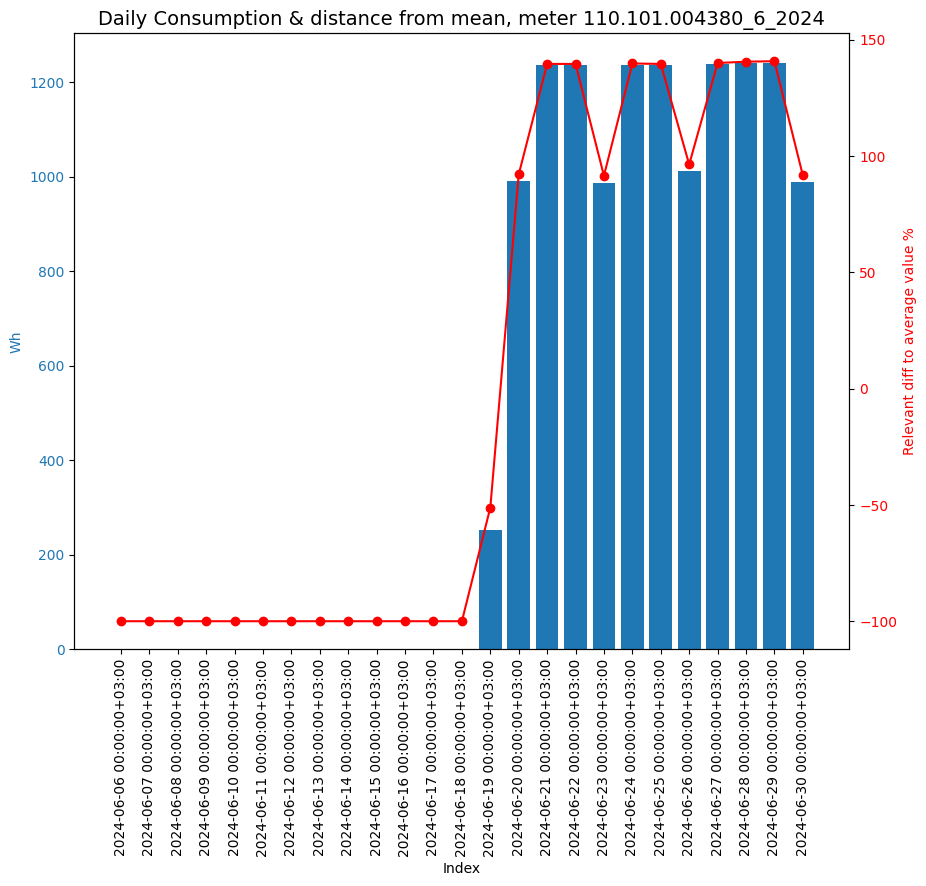

110.101.004381


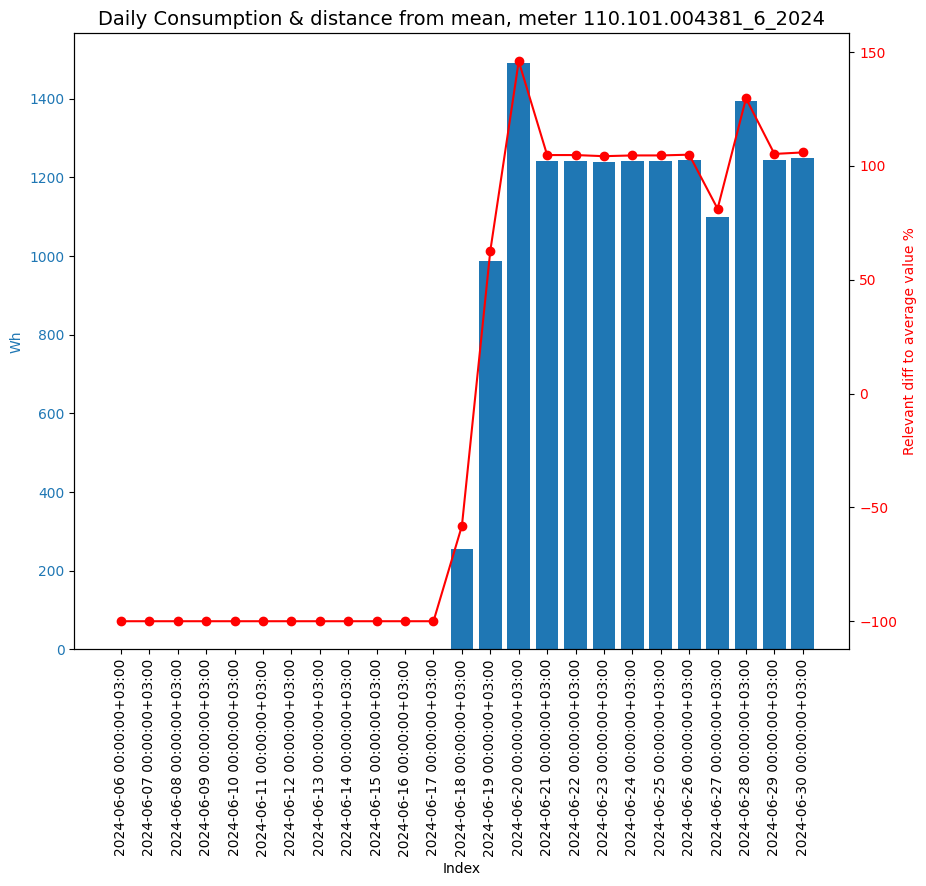

110.101.004382


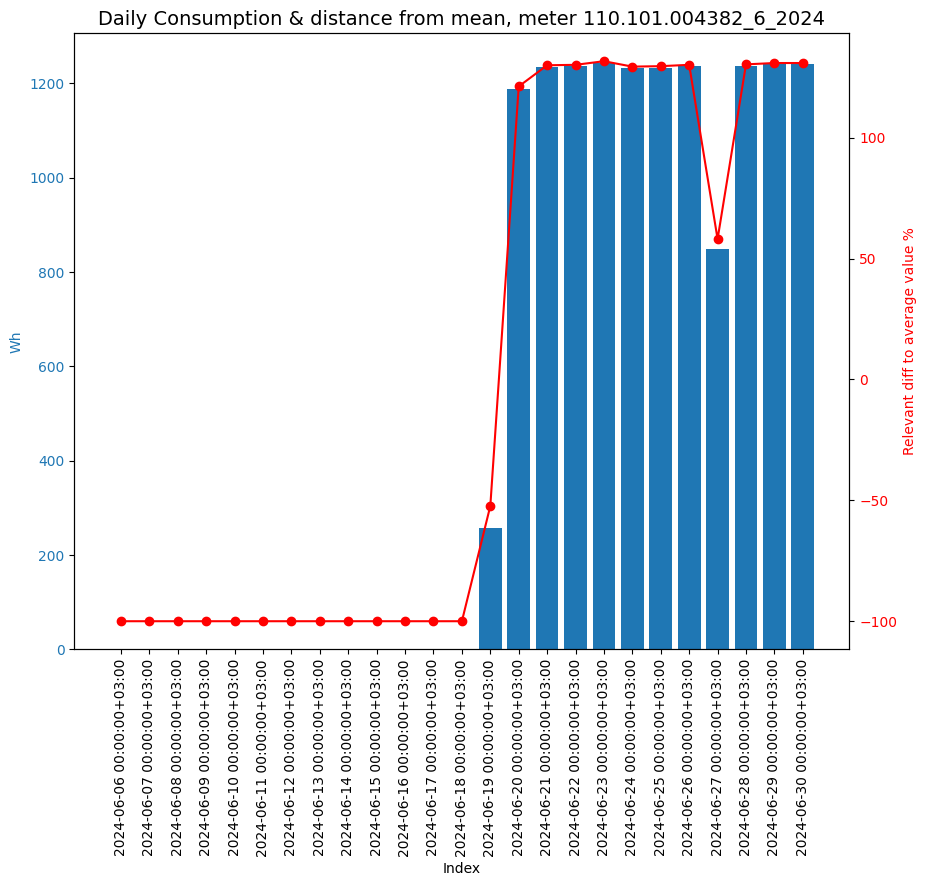

110.101.004376


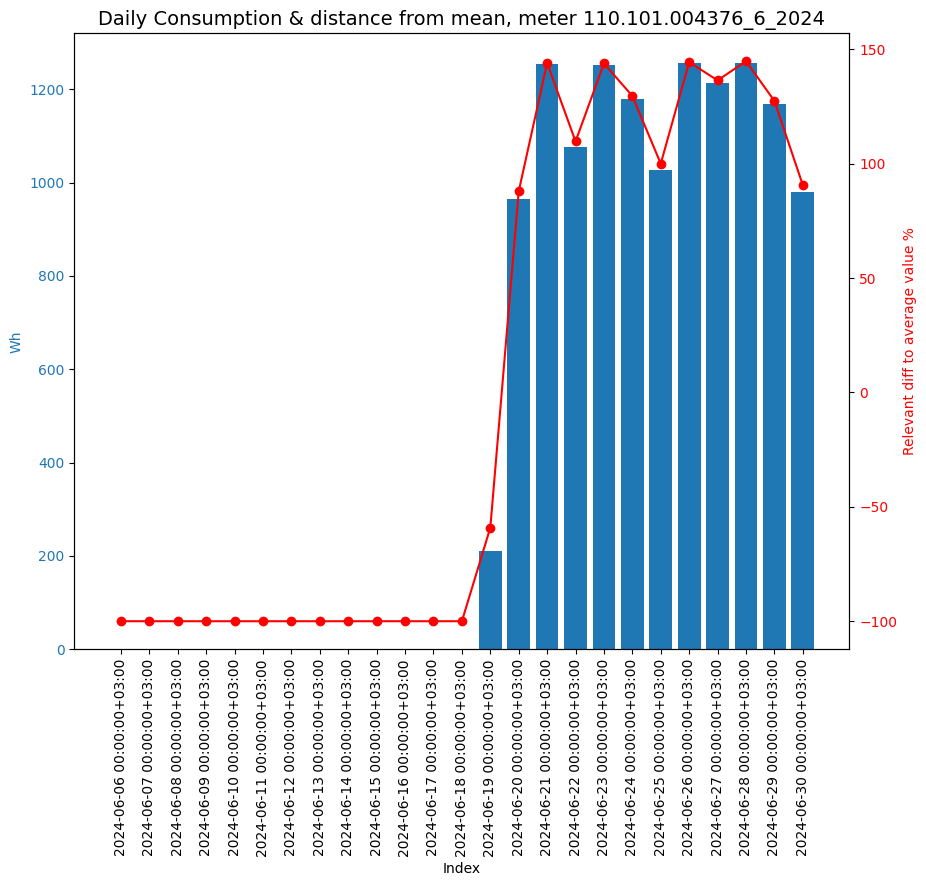

110.101.004374


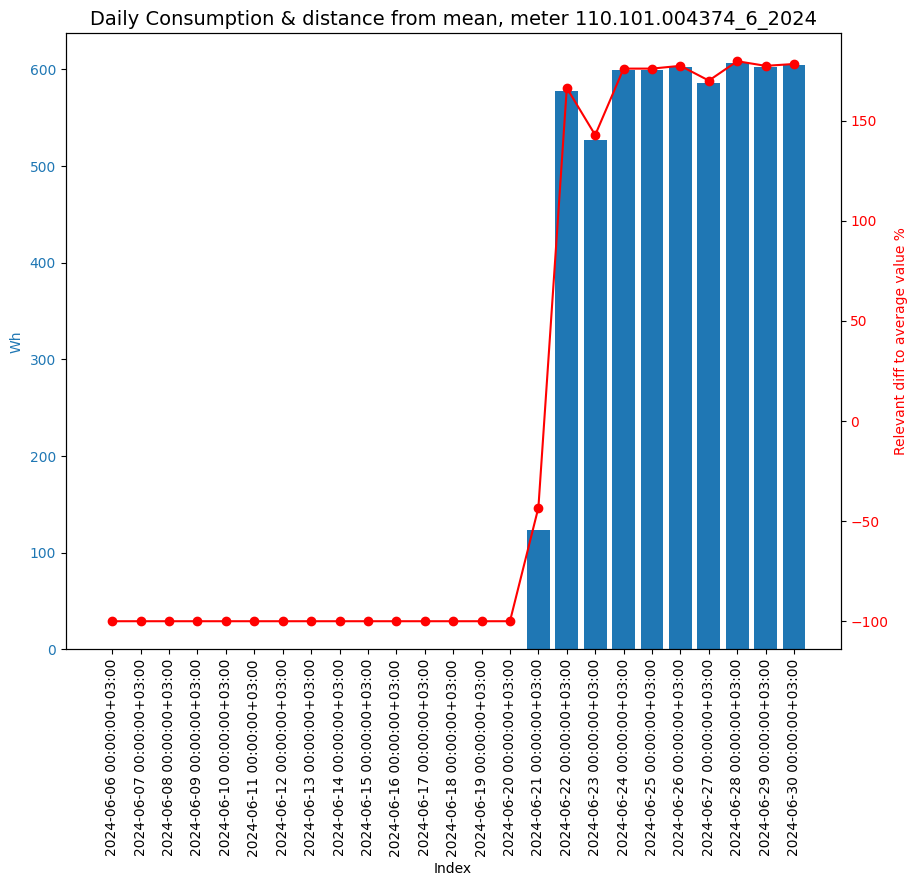

110.101.004371


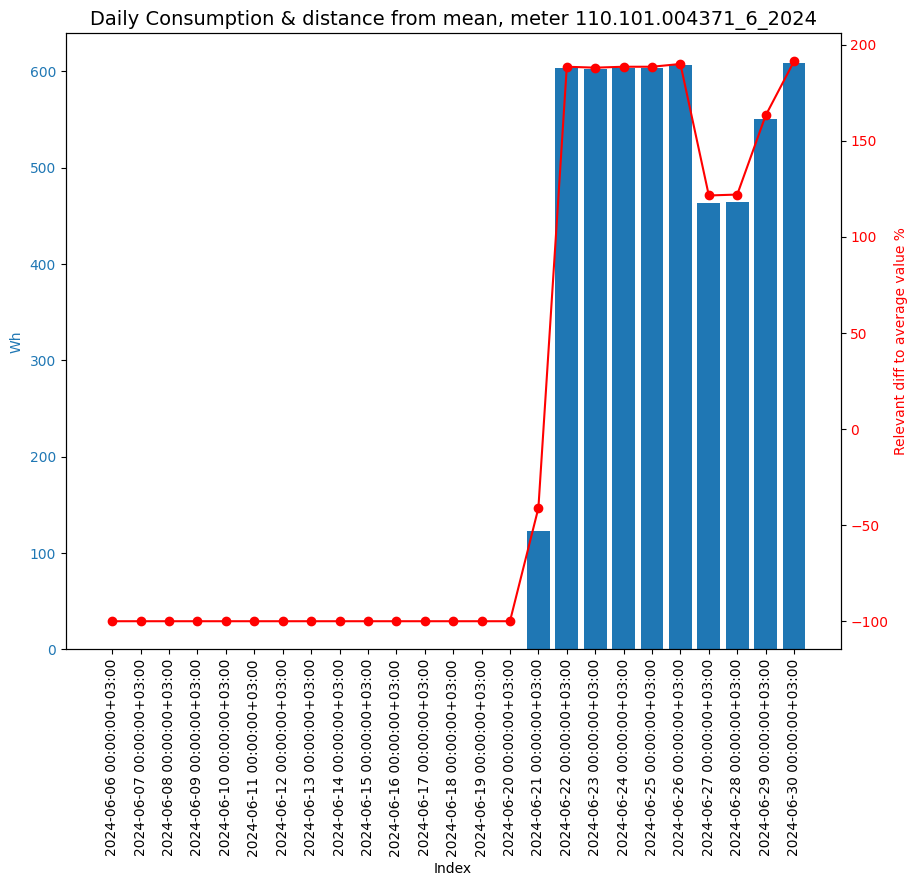

110.101.004335


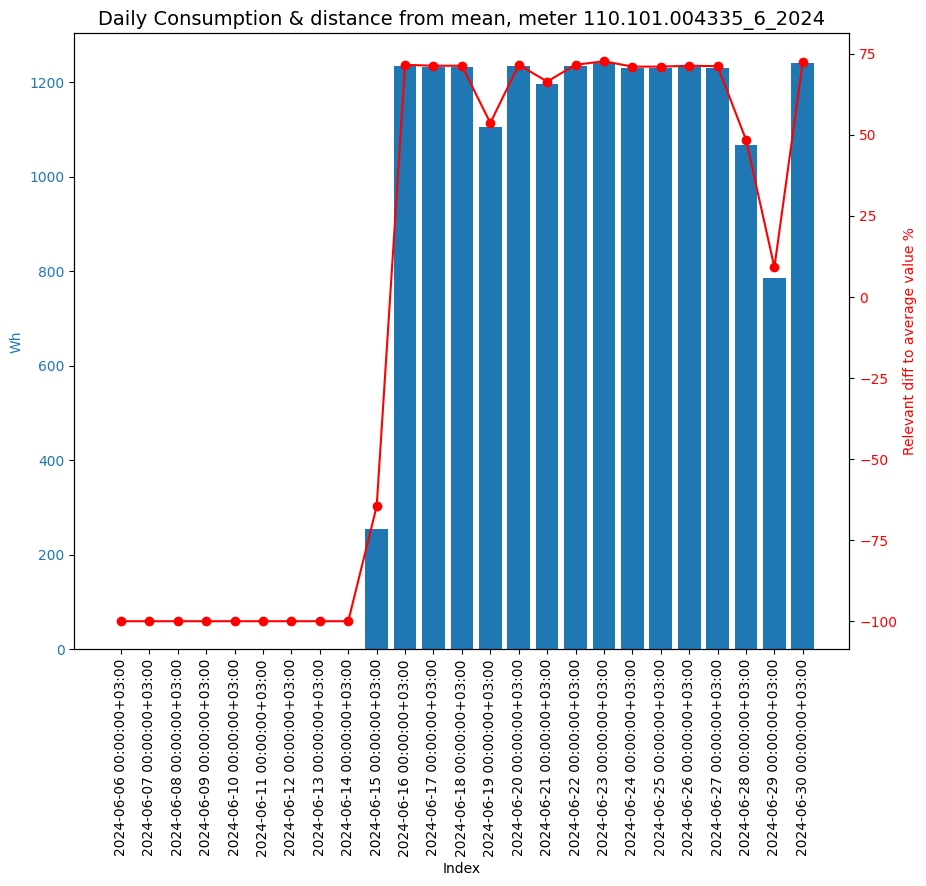

110.101.004347


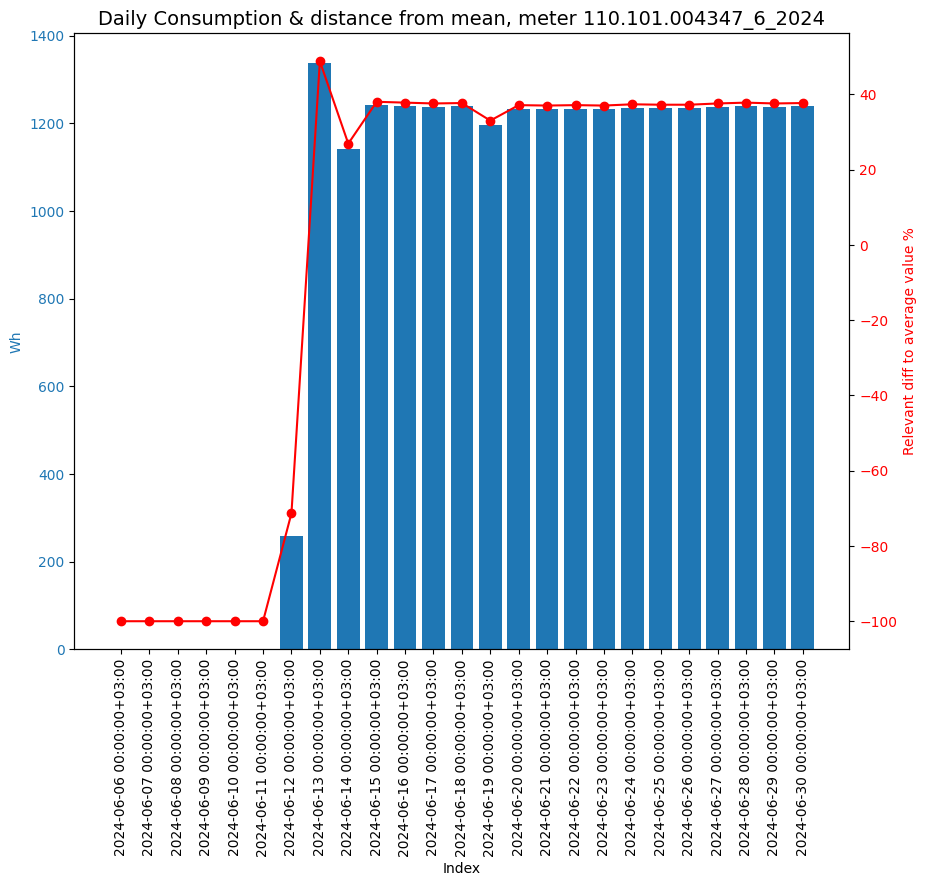

110.101.004348


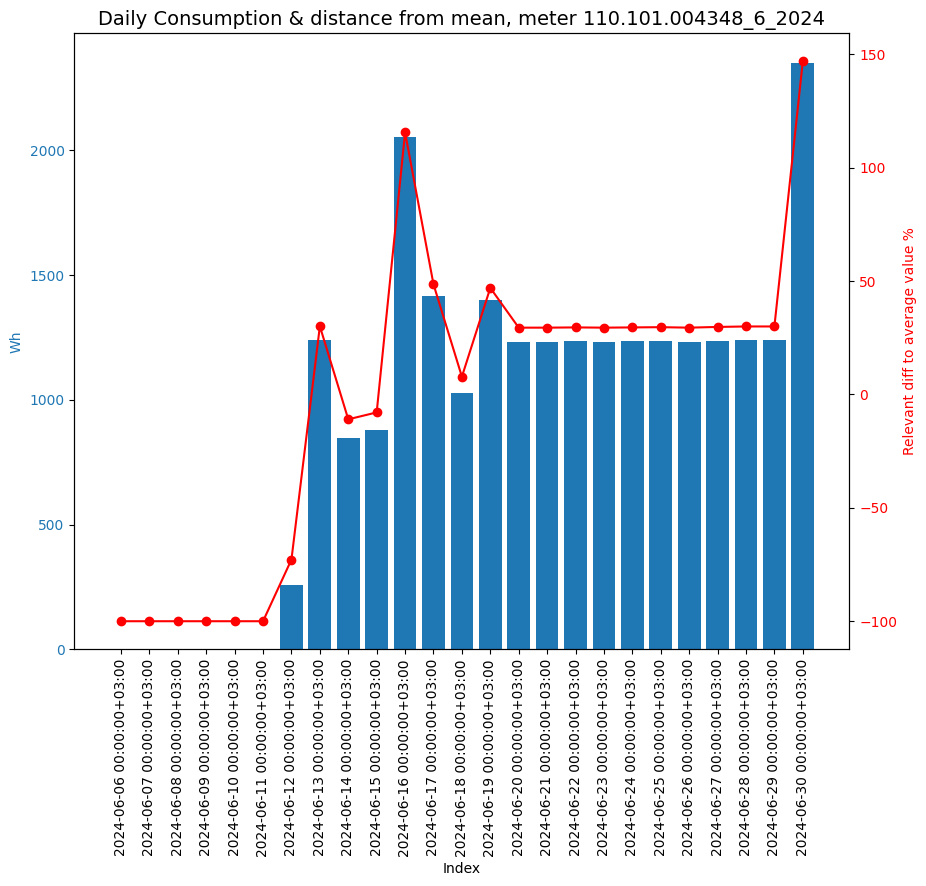

110.101.004346


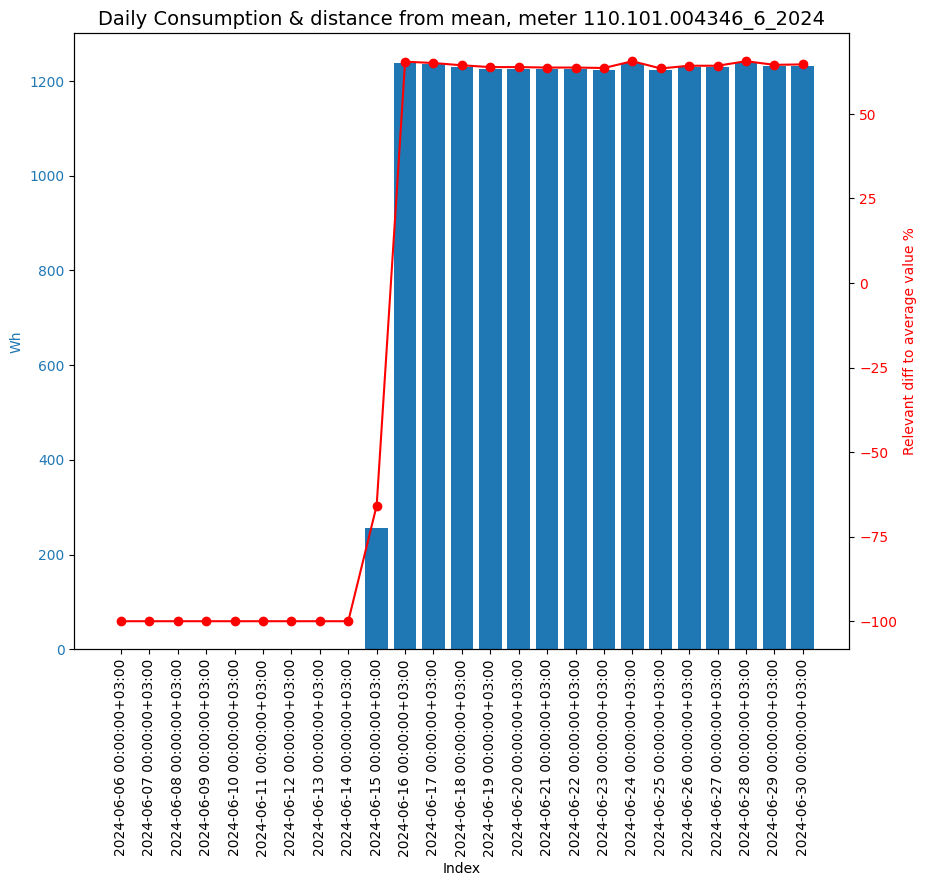

110.101.004345


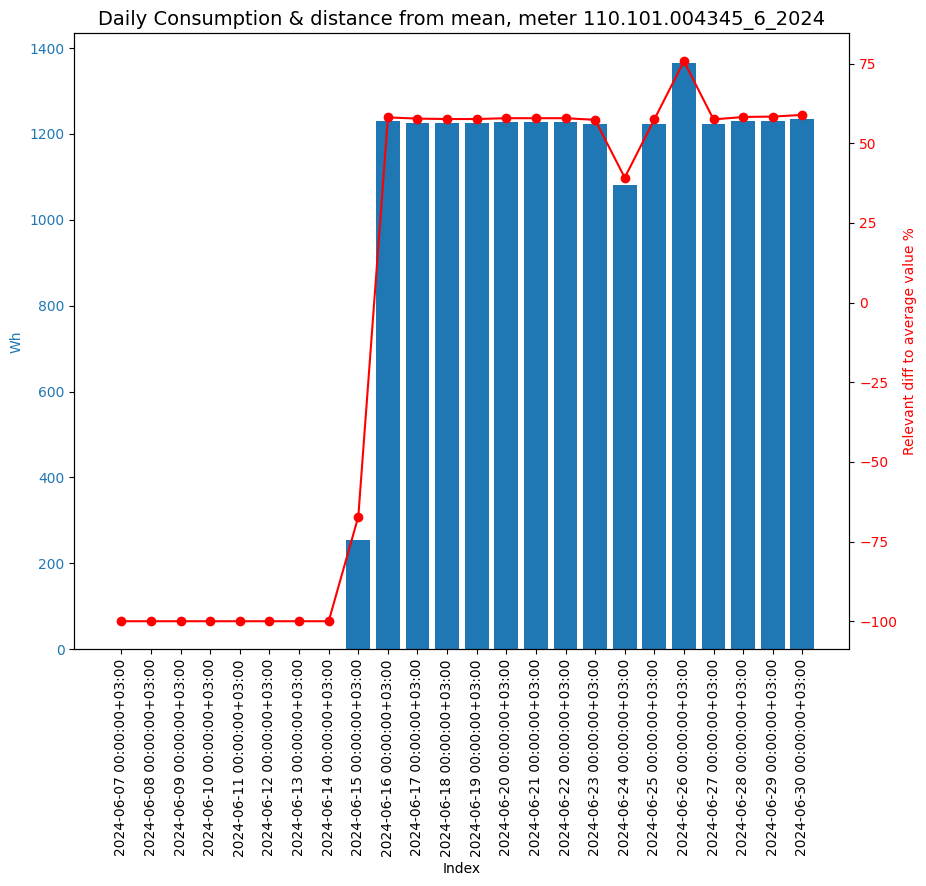

110.101.004349


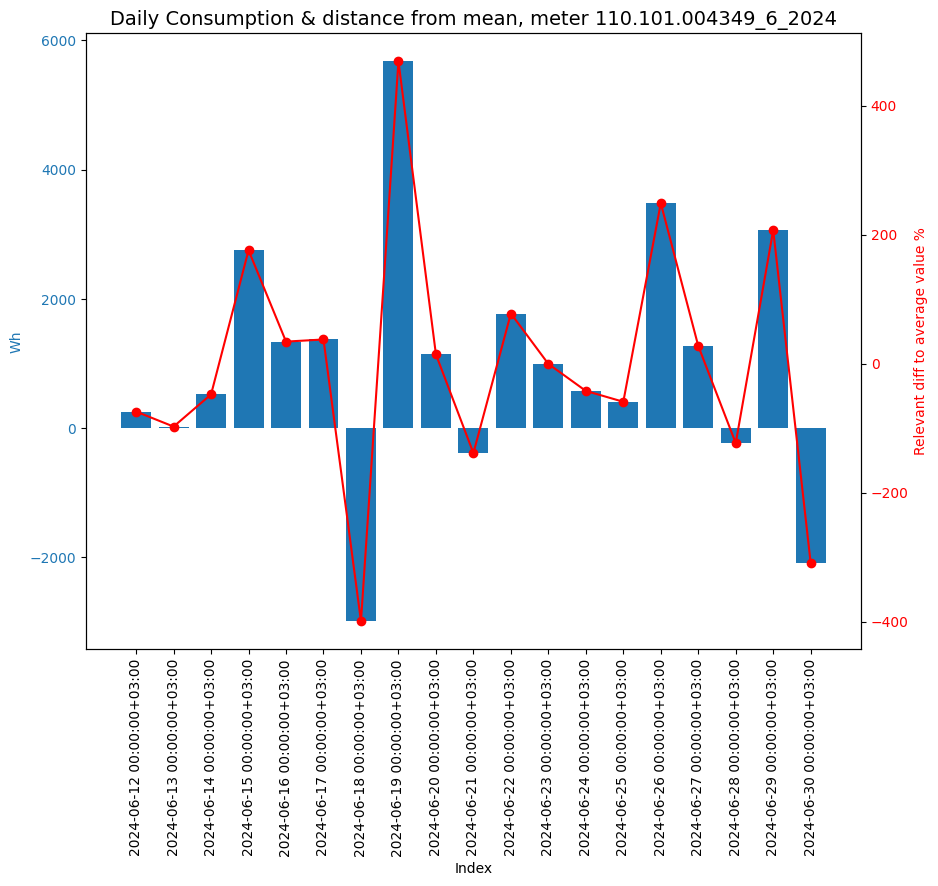

110.101.004342


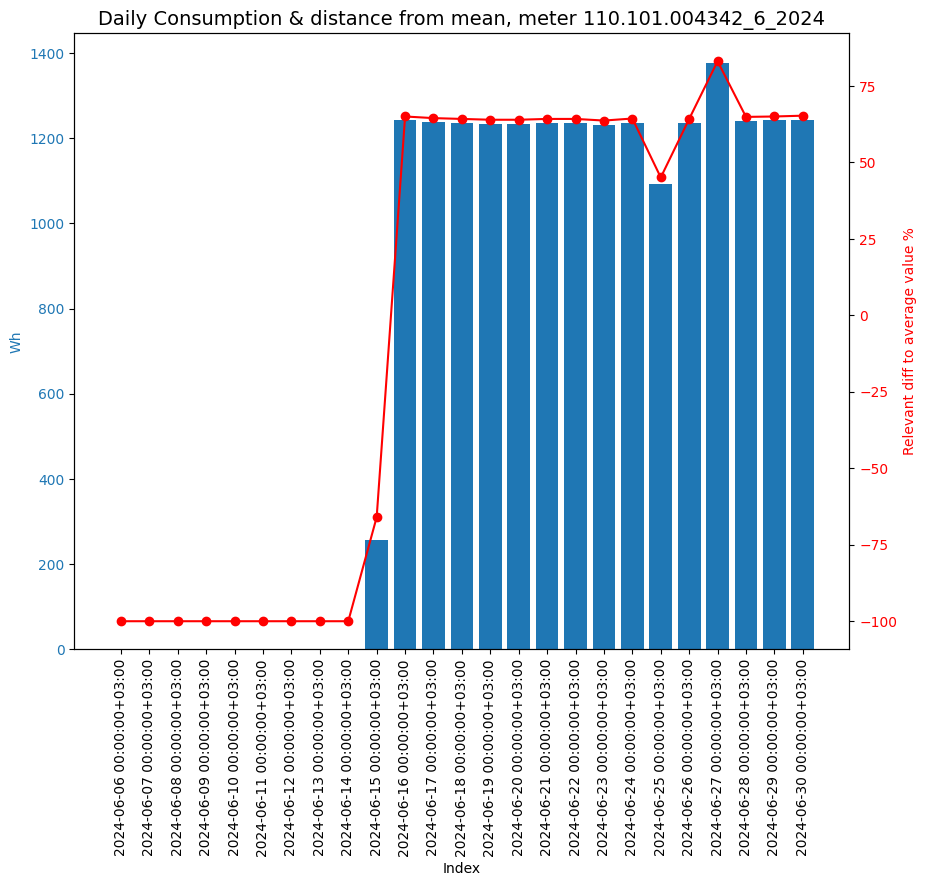

110.101.004339


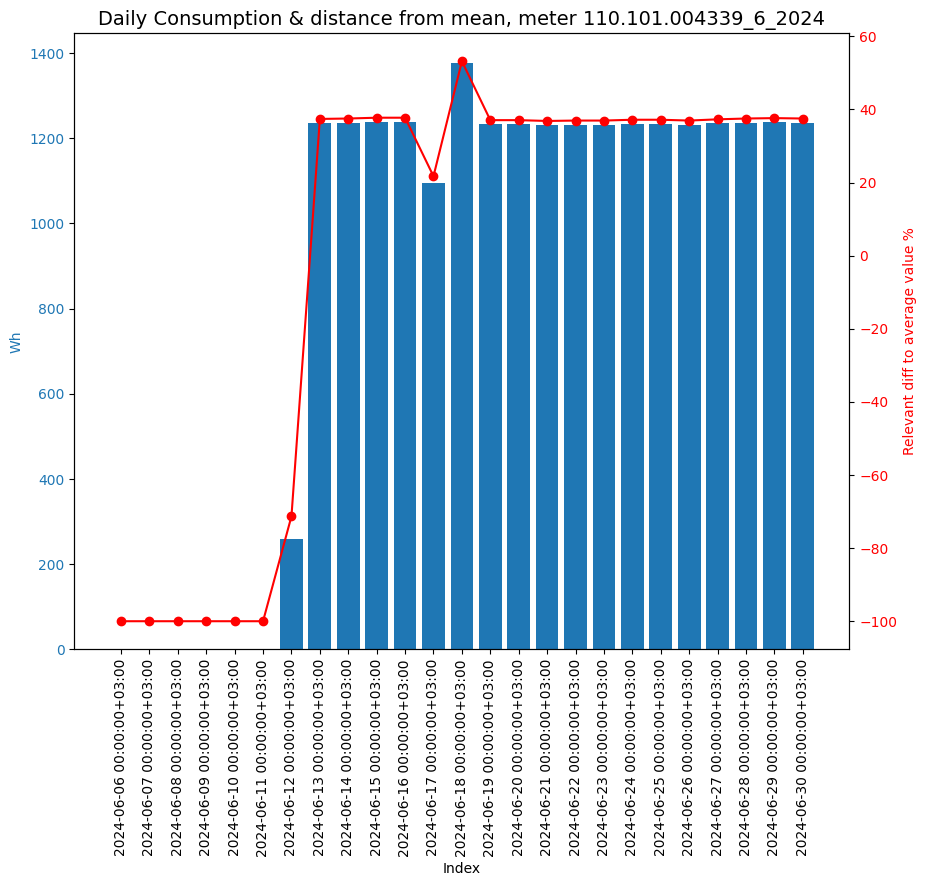

110.101.004336


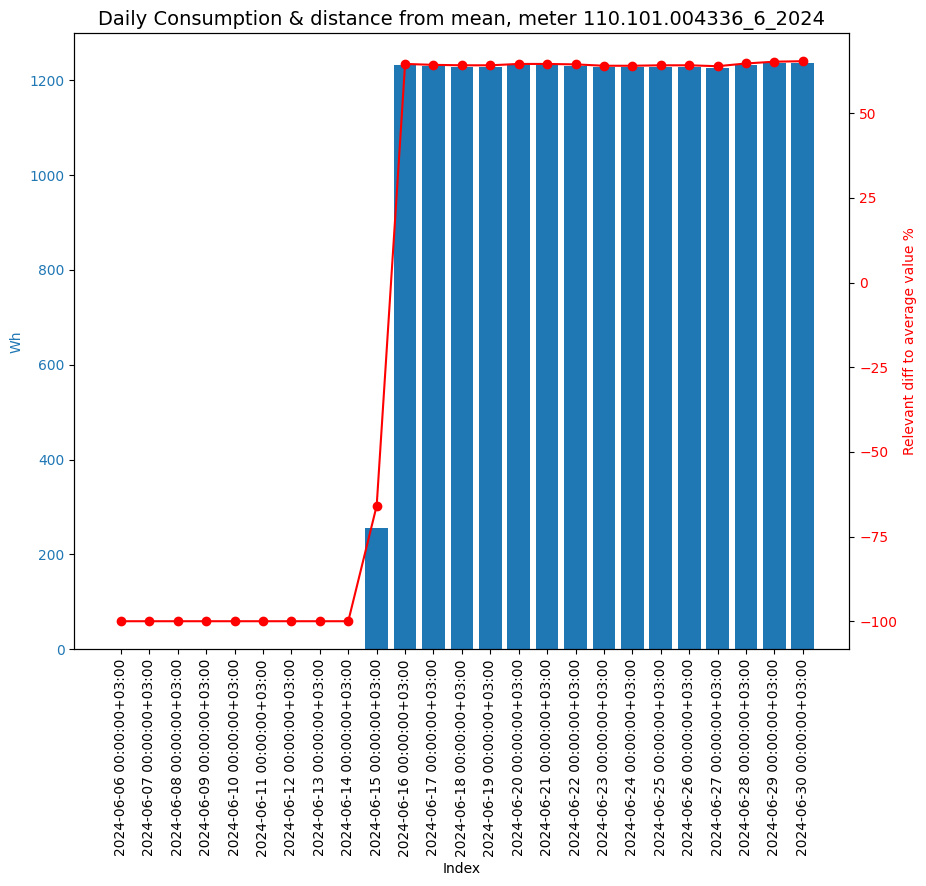

110.101.004337


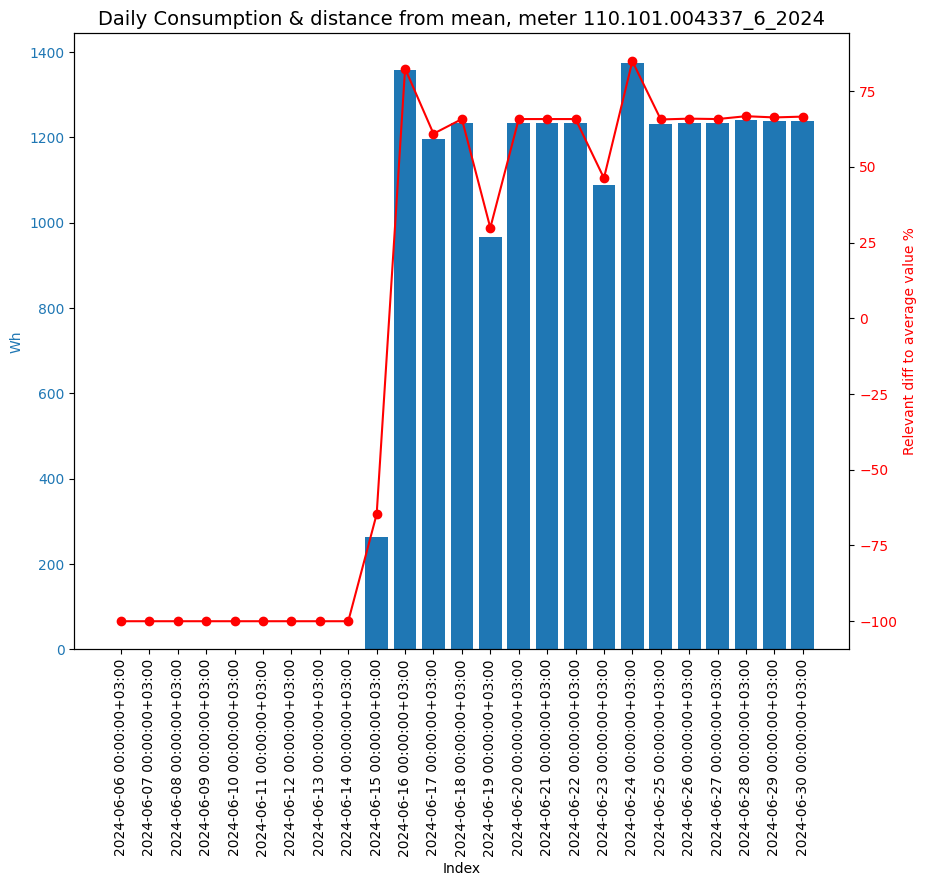

110.101.003845


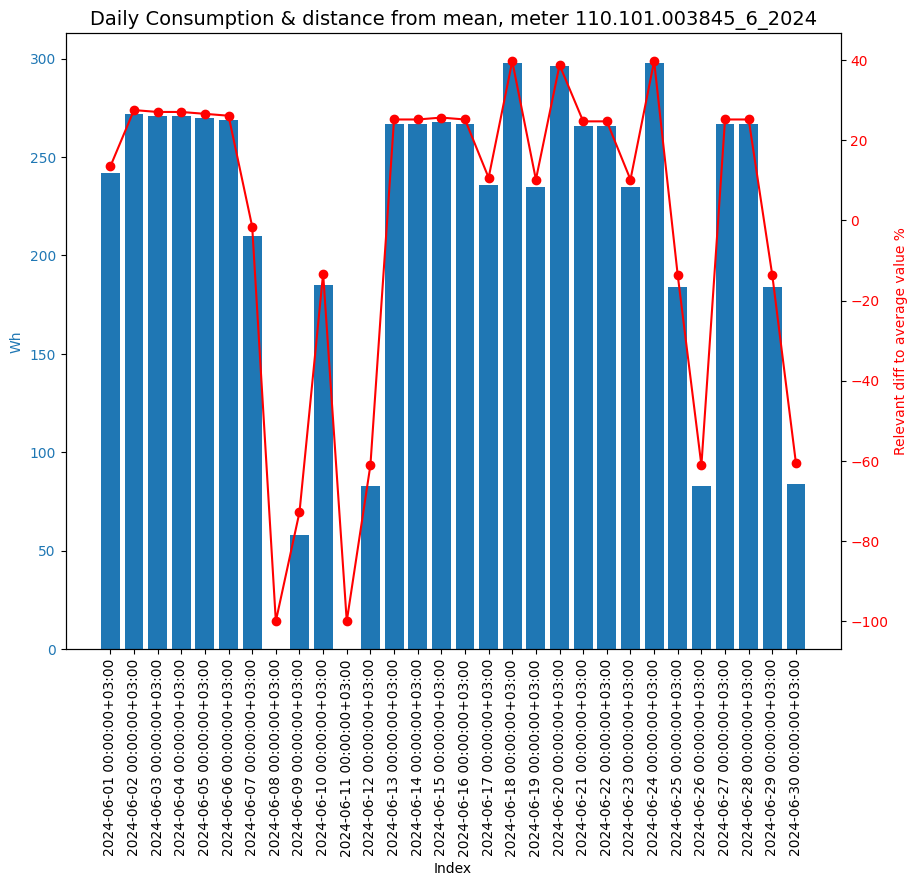

110.101.003899


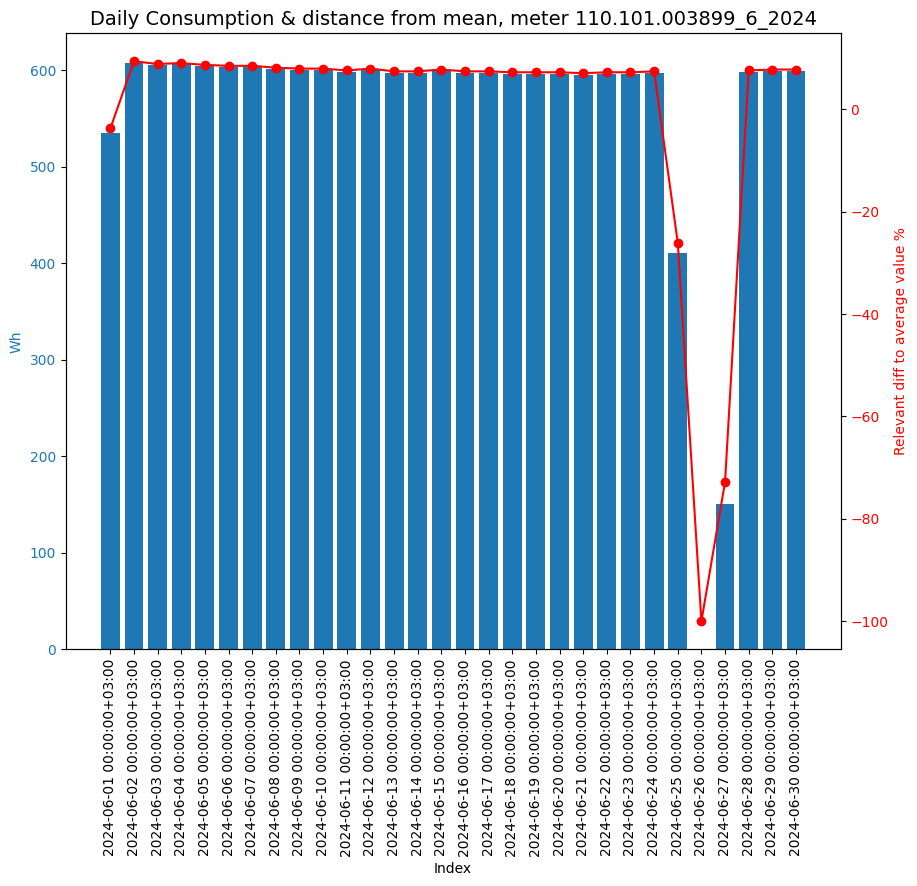

110.101.003652


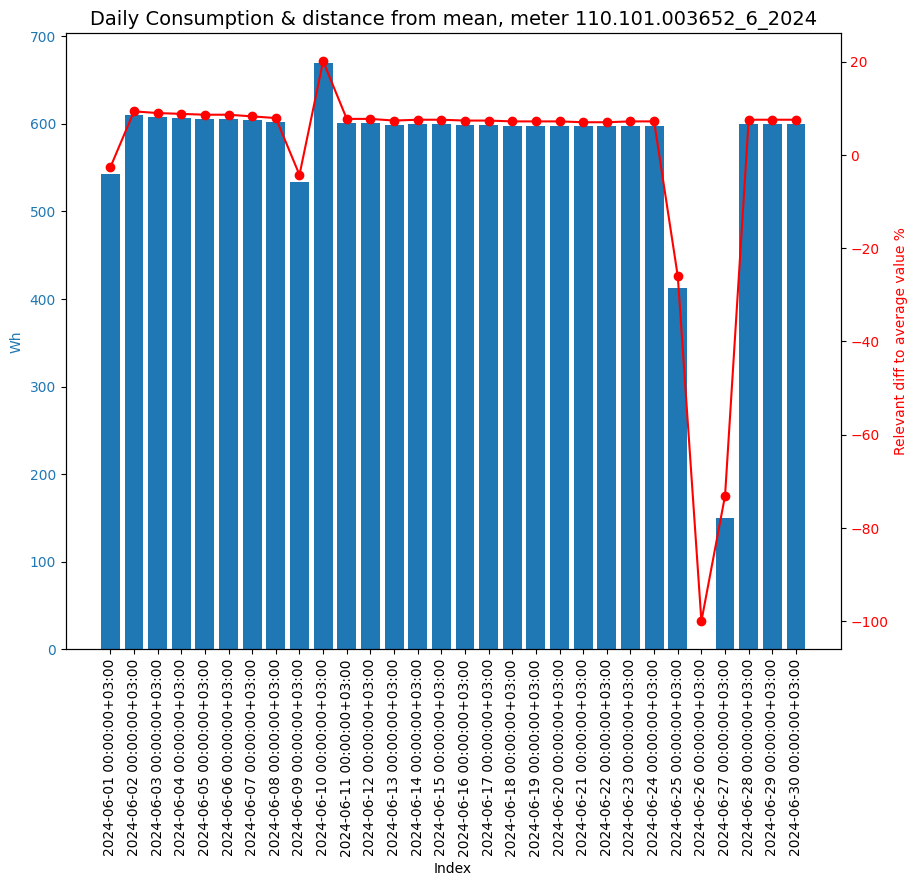

110.101.003648


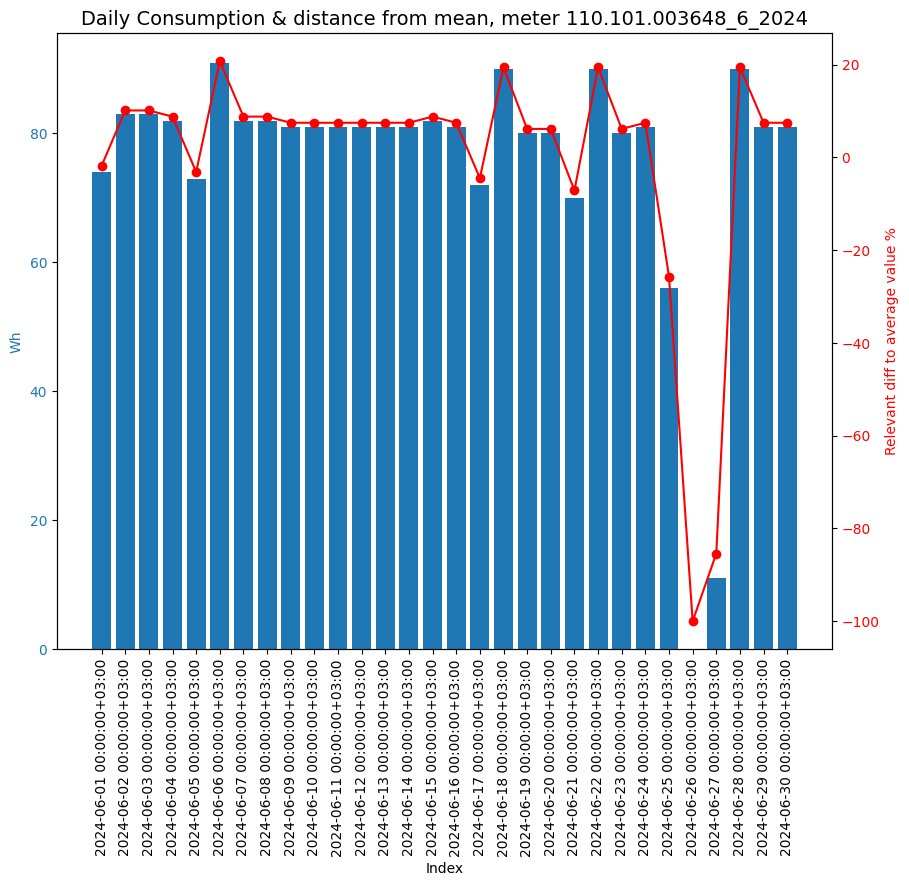

110.101.003626


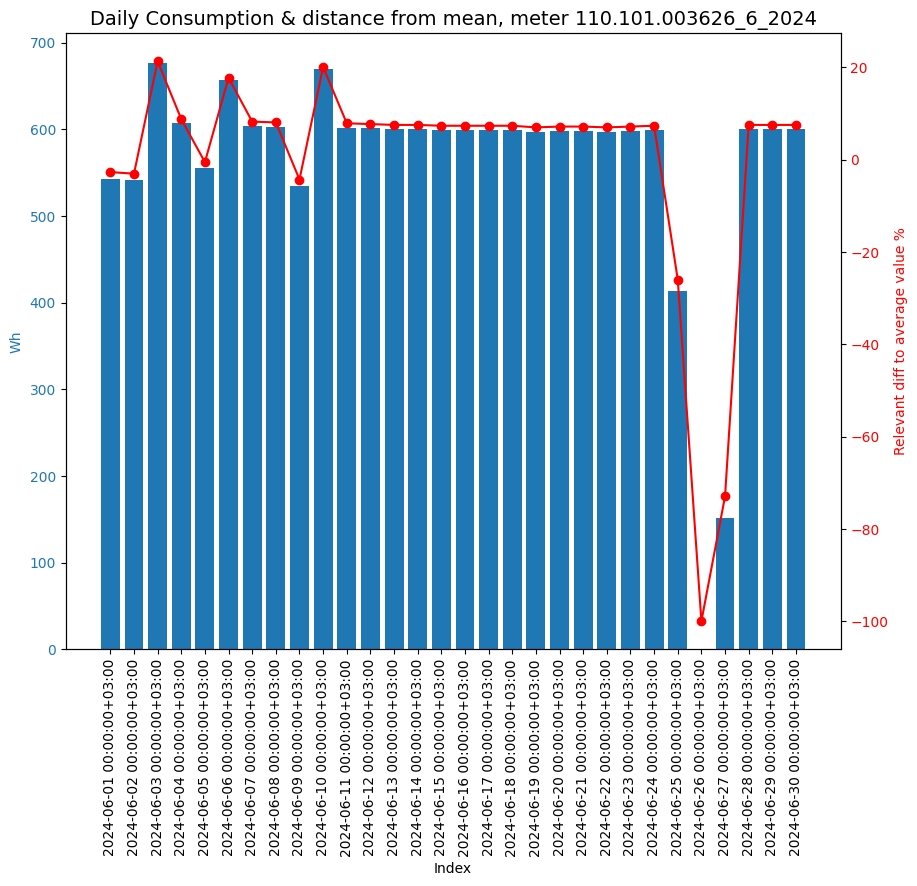

110.101.003338


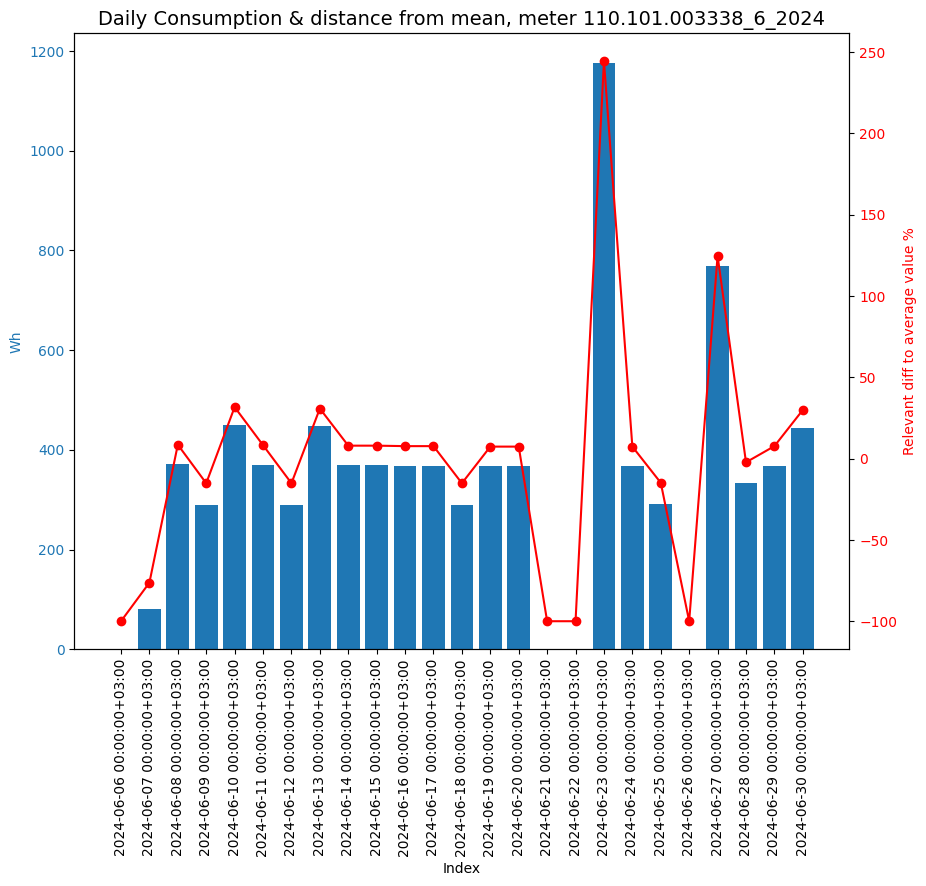

In [31]:
url = "https://mi6.meazon.com"
acc_token = get_access_token(url)
entity='device'
month = 6
year = 2024
startm = datetime.datetime(year = year, month=month, day=1)
endm = startm + relativedelta(months=1)
tmzn = pytz.timezone('Europe/Athens')    
endm = tmzn.localize(endm)
startm = tmzn.localize(startm)
end_time = str(int((endm ).timestamp() * 1000))
start_time = str(int((startm ).timestamp() * 1000))

prefix = 'Corinth_'
entityid = "66310990-d7bb-11ee-ad9c-9bc116507662" # NEMA Corinth
# prefix = 'Heraklio_'
# entityid = "1749b100-6282-11ee-b2c9-653b42f73605" # ILC Irakleio
for page in range(12):
    r2 = requests.get(url=url + "/api/entityGroup/"+entityid+"/entities?pageSize=100&page="+str(page),headers={'Content-Type': 'application/json', 'Accept': '*/*', 'X-Authorization': acc_token}).json()

    for contr in r2['data']:
        devid = contr['id']['id']
        name = contr['name']
        df = read_data(url, devid, acc_token, start_time, end_time, 'cnrgA', entity, tmzn)
        if not df.empty:
            df['delta'] = df['cnrgA'] - df['cnrgA'].shift()
            df['delta'] = df['delta']#/1000
            df = df.resample('1D').sum()
            mean_value = df['delta'].mean()
            df['diff'] = (df['delta'] - mean_value) / mean_value * 100

            if not df.loc[(df['diff'].shift()<-90) & (df['diff']<-40) & (df['diff']>-99)].empty:
                print(name)
                plot_error(df,name, month, year, prefix)
        #& (df['diff']>-99)